# This notebook examines the general trends in FAC data
A more thorough writeup can be found in https://drive.google.com/open?id=1U6stzP7qhqB3B10kNYnWdlgtAibwoFEI6cuKOSSq-ZU

In [18]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
general_df = pd.read_pickle(processed_path + 'general.pkl')
# print('General DF\n', general_df.head())

# Agency prefix dictionary:
with open(processed_path + 'agency_dict', 'rb') as f_w:
    agency_dict = pickle.load(f_w)
# Entity code dictionary:
with open(processed_path + 'entity_dict', 'rb') as f_w:
    entity_dict = pickle.load(f_w)

## Add columns indicating any type of issue for financial statements or major programs

In [35]:
mp_list = ['REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP', ]
fs_list = ['REPORTABLECONDITION', 'MATERIALWEAKNESS', 'MATERIALNONCOMPLIANCE', 'QCOSTS']
general_df = general_df.assign(
    fs_any=pd.Series(general_df[[i for i in fs_list]].sum(axis=1).str.count('Y'))
)
general_df = general_df.assign(
    mp_any=pd.Series(general_df[[i for i in mp_list]].sum(axis=1).str.count('Y'))
)

## Type of Opinions

Index(['905', '100', '403', '904', '200', '909', '888', '903', '908', '505'], dtype='object')
Index(['97', '17', '16', '12', '20', '  ', '10', '93', '84', '14'], dtype='object')
Index(['NC', 'MA', 'FL', 'MI', 'IL', 'OH', 'PA', 'TX', 'NY', 'CA'], dtype='object')


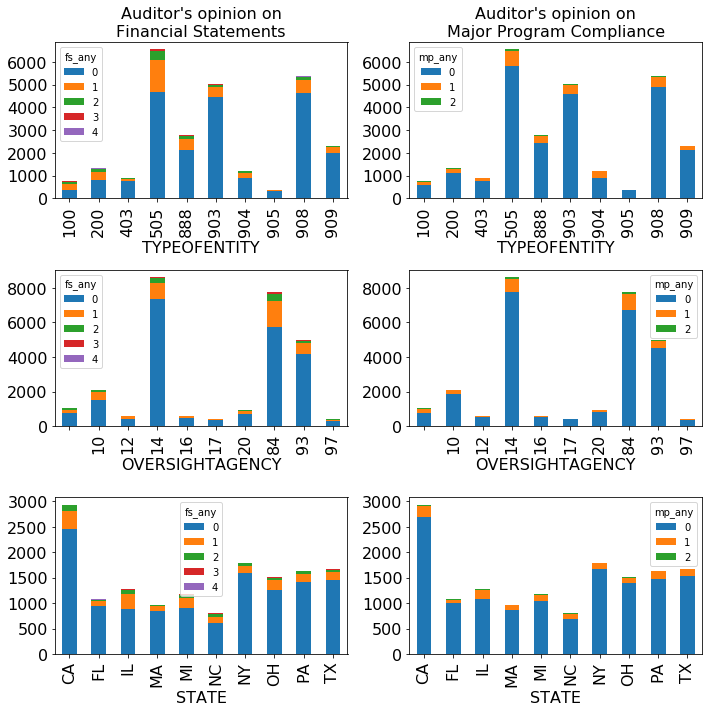

In [37]:
year = 2017
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for (index, sortby) in enumerate(['TYPEOFENTITY', 'OVERSIGHTAGENCY', 'STATE']):
    year_df = general_df[general_df['AUDITYEAR'] == year]
    sortby_sorted = year_df[sortby].value_counts(ascending=True)  # Sort df for year by counts entity count
    top_10_sortby = sortby_sorted.index[-10:]  # Take 10 most represented entities
    
    top_10_sortby_df = year_df[year_df[sortby].isin(top_10_sortby)]  # Create dataframe for top 10 entities
    typereport_fs_plot = top_10_sortby_df.\
    groupby(sortby)['fs_any'].value_counts().unstack(level=1)[
        [0, 1, 2, 3, 4]  # Select these opinions to plot
    ].\
    plot(
        kind='bar', fontsize=16, stacked=True, ax=axes[index, 0]
    )
    if index == 0:
        typereport_fs_plot.set_title('Auditor\'s opinion on\nFinancial Statements', fontsize=16)
    typereport_fs_plot.set_xlabel(sortby, fontsize=16)

    typereport_fs_plot = top_10_sortby_df.\
    groupby(sortby)['mp_any'].value_counts().unstack(level=1)[
        [0, 1, 2]
    ].\
    plot(
        kind='bar', fontsize=16, stacked=True, ax=axes[index, 1]
    )
    if index == 0:
        typereport_fs_plot.set_title('Auditor\'s opinion on\nMajor Program Compliance', fontsize=16)
    typereport_fs_plot.set_xlabel(sortby, fontsize=16)
    print(top_10_sortby)
plt.tight_layout()
plt.show()
states = list(top_10_sortby)

## Plot percent of all audits by entity type

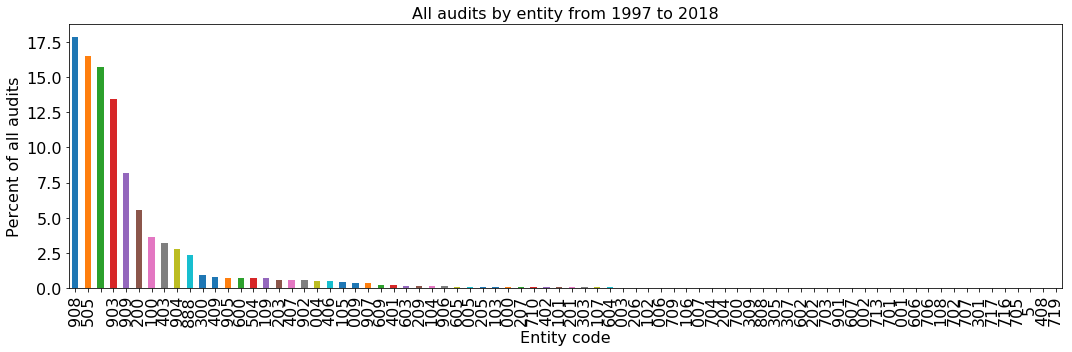

Total number of audits: 815883


In [38]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = general_df.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(general_df) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16)
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16)
percent_audits_plot.set_title(
    'All audits by entity from %s to %s' %(min(general_df['AUDITYEAR']), max(general_df['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(general_df))

In [4]:
entity_dict['908']

'Non-profit Social Services Organization'

## Plot percent of audits with at least 2 FS issues by entity type

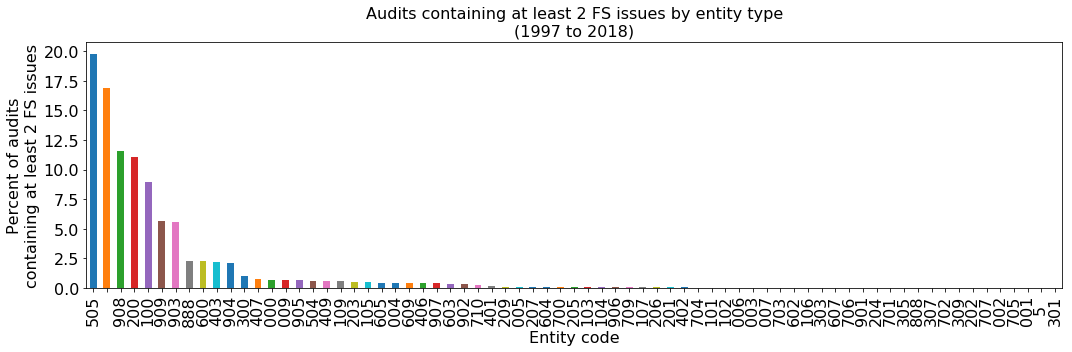

Total number of audits: 91882


In [51]:
fs_any_df = general_df[(general_df['fs_any'] == 2) | (general_df['fs_any'] == 3) | (general_df['fs_any'] == 4)]
entity_groups = fs_any_df.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(fs_any_df) * 100


fig, axes = plt.subplots(figsize=(15, 5))
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16)
percent_audits_plot.set_ylabel('Percent of audits\ncontaining at least 2 FS issues', fontsize=16)
percent_audits_plot.set_title(
    'Audits containing at least 2 FS issues by entity type\n(%s to %s)' %(min(fs_any_df['AUDITYEAR']), max(fs_any_df['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(fs_any_df))

## Plot ILEA audits by audit finding

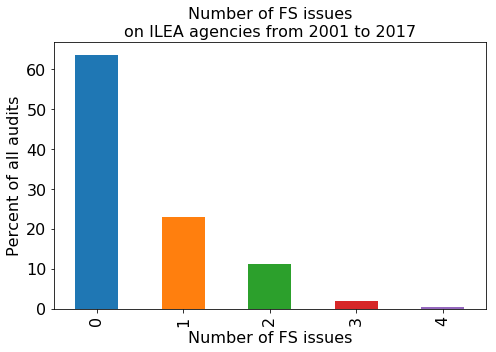

Total number of audits: 134866


In [66]:
# Note: because we are looking for audits containing opinion, the sum of op_series is greater than 1
ilea_df = general_df[general_df['TYPEOFENTITY'] == '505']
op_list = [0, 1, 2, 3, 4]
op_groups = ilea_df.groupby('fs_any').size()
op_groups = (op_groups / sum(op_groups)) * 100


fig, axes = plt.subplots(figsize=(7, 5))
percent_505_audits_plot = op_groups.plot(kind='bar', fontsize=16)
percent_505_audits_plot.set_xlabel('Number of FS issues', fontsize=16)
percent_505_audits_plot.set_ylabel('Percent of all audits', fontsize=16)
percent_505_audits_plot.set_title(
    'Number of FS issues\non ILEA agencies from %s to %s' %(min(ilea_df['AUDITYEAR']), max(ilea_df['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(ilea_df))

## Plot percentage of all ILEAs that have at least one FS issue

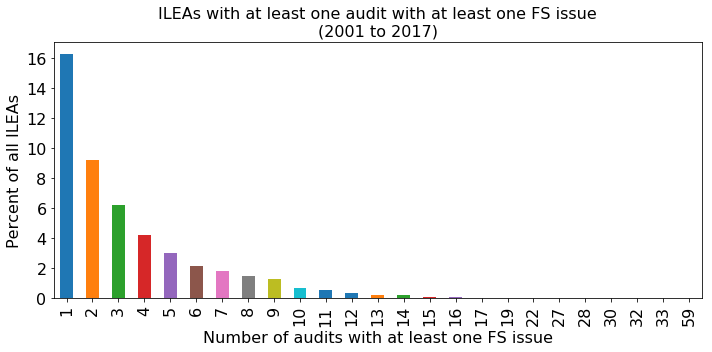

Total number of ILEAs (over all time, over all types of audits): 11255


In [73]:
fs_any_eins = set(fs_any_df[fs_any_df['TYPEOFENTITY'] == '505']['EIN'])

        
ilea_audit_dict = {}
for name, group in ilea_df[ilea_df['EIN'].isin(fs_any_eins)].groupby(['EIN', 'fs_any']):
    ein = name[0]
    audit_opinion = name[1]
    if audit_opinion > 1:
        number_fs_any_audit = len(group)
        if ein not in ilea_audit_dict.keys():
            ilea_audit_dict[ein] = 0
        ilea_audit_dict[ein] += number_fs_any_audit


# Remap dictionary of ILEAs with A/D audits into dictionary of
# years of bad audits and number of ILEAs
fs_any_audit_dict = {}
for ein, number_fs_any_audits in ilea_audit_dict.items():
    if number_fs_any_audits not in fs_any_audit_dict.keys():
        fs_any_audit_dict[number_fs_any_audits] = 0
    fs_any_audit_dict[number_fs_any_audits] += 1   
fs_any_audit_series = pd.Series(fs_any_audit_dict).sort_index() / ilea_df['EIN'].nunique() * 100


fig, axes = plt.subplots(figsize=(10, 5))
fs_any_audit_plot = fs_any_audit_series.plot(kind='bar', fontsize=16)
fs_any_audit_plot.set_xlabel('Number of audits with at least one FS issue', fontsize=16)
fs_any_audit_plot.set_ylabel('Percent of all ILEAs', fontsize=16)
fs_any_audit_plot.set_title(
    'ILEAs with at least one audit with at least one FS issue\n(%d to %d)' \
    %(min(ilea_df[ilea_df['EIN'].isin(fs_any_eins)]['AUDITYEAR']), max(ilea_df[ilea_df['EIN'].isin(fs_any_eins)]['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of ILEAs (over all time, over all types of audits):', ilea_df['EIN'].nunique())

## Plot percentage of A/D ILEA audits by state

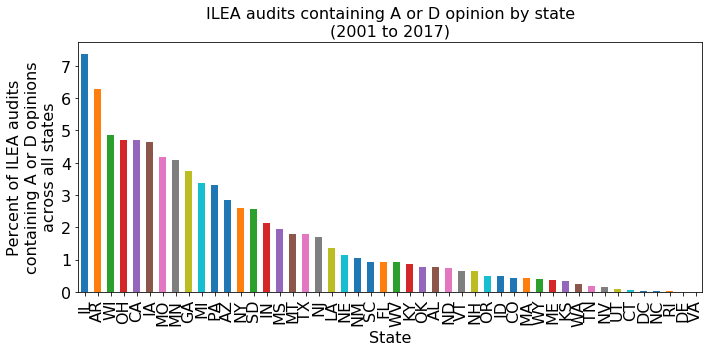

Total number of A/D ILEA audits: 18188


In [74]:
fig, axes = plt.subplots(figsize=(10, 5))
state_fs_any_ilea_df = fs_any_df[fs_any_df['EIN'].isin(ad_eins)]
state_fs_any_ilea_df = state_fs_any_ilea_df[state_fs_any_ilea_df['TYPEOFENTITY'] == '505']
state_fs_any_ilea_series = state_fs_any_ilea_df[state_fs_any_ilea_df['TYPEOFENTITY'] == '505'].groupby(['STATE']).\
    size().sort_values(ascending=False) / len(fs_any_df[fs_any_df['EIN'].isin(ad_eins)]) * 100
state_fs_any_ilea_plot = state_fs_any_ilea_series.plot(kind='bar', fontsize=16)
state_fs_any_ilea_plot.set_xlabel('State', fontsize=16)
state_fs_any_ilea_plot.set_ylabel('Percent of ILEA audits\ncontaining A or D opinions\nacross all states', fontsize=16)
state_fs_any_ilea_plot.set_title(
    'ILEA audits containing A or D opinion by state\n(%d to %d)' \
    %(min(state_fs_any_ilea_df['AUDITYEAR']), max(state_fs_any_ilea_df['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of A/D ILEA audits:', len(state_fs_any_ilea_df))

## Plot ILEA trends over time by state

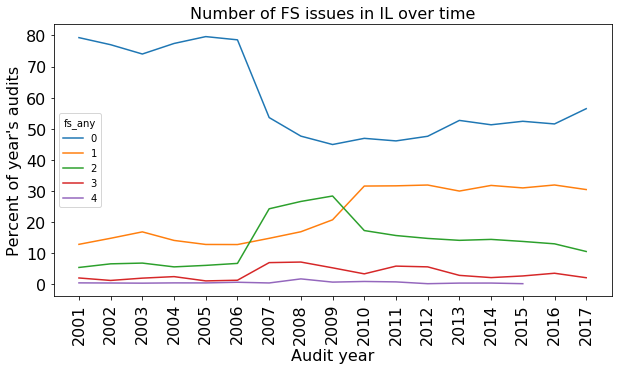

In [86]:
state = 'IL'
op_list = [0, 1, 2, 3, 4]
state_df = ilea_df[ilea_df['STATE'] == state]
state_df = state_df.groupby('AUDITYEAR')['fs_any'].value_counts().unstack(level=1)
state_op_df = state_df.div(state_df.sum(axis=1), axis=0) * 100  # normalize each year by state_df total


fig, axes = plt.subplots(figsize=(10, 5))
state_plot = state_op_df.plot(
    y=op_list, fontsize=16, ax=axes, xticks=state_op_df.index, rot=90
)
state_plot.set_xlabel('Audit year', fontsize=16)
state_plot.set_ylabel('Percent of year\'s audits', fontsize=16)
state_plot.set_title('Number of FS issues in %s over time' %state, fontsize=16)
plt.show()
# state_df_sorted